# 4.1 Compare models

In [1]:
import os
import sys
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import report
import block_sampler
import batch_encoder
import callbacks
from dataset import Dataset

from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, TimeDistributed, Flatten, Dot, Softmax, Lambda, RepeatVector, Multiply, Permute, Reshape, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from trainer import TrainResults

/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dty

In [2]:
tf.__version__, tf.keras.__version__

('1.14.0', '2.2.4-tf')

In [3]:
tf.test.is_gpu_available(), tf.test.is_built_with_cuda()

(False, False)

In [4]:
raw_dataset_folder='govdocs1/sample200'
minimum=200
maximum=200
result_dir = 'results/4.1-compare-models'
os.makedirs(result_dir, exist_ok=True)

In [5]:
rawset = Dataset.new_from_folders(raw_dataset_folder).filter_min_max(minimum, maximum)
rawset = rawset.filter(lambda x: rawset.category_from(x) not in ['text', 'unk'])
rawset.rebuild_categories()

In [6]:
tset, vset = rawset.rnd_split_fraction_by_category(0.5)

# Create models

In [7]:
def D(classes, len_byte_vector):
    last = l0 = Input(shape=(512,len_byte_vector))
    last = Flatten()(last)
    last = Dense(classes)(last)
    last = Activation('softmax')(last)
    name = sys._getframe().f_code.co_name
    model = tf.keras.Model([l0], last, name=name)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['binary_accuracy', 'categorical_accuracy'])
    return model

In [8]:
def LD(classes, len_byte_vector):
    last = l0 = Input(shape=(512,len_byte_vector))
    last = LSTM(32)(last)
    last = Dense(classes)(last)
    last = Activation('softmax')(last)
    name = sys._getframe().f_code.co_name
    model = tf.keras.Model([l0], last, name=name)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['binary_accuracy', 'categorical_accuracy'])
    return model

In [9]:
def LL(classes, len_byte_vector):
    last = l0 = Input(shape=(512,len_byte_vector))
    last = LSTM(32, return_sequences=True)(last)
    last = LSTM(classes)(last)
    last = Activation('softmax')(last)
    name = sys._getframe().f_code.co_name
    model = tf.keras.Model([l0], last, name=name)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['binary_accuracy', 'categorical_accuracy'])
    return model

In [10]:
def CD(classes, len_byte_vector):
    last = l0 = Input(shape=(512,len_byte_vector))
    last = Conv1D(64,(64,),strides=8)(last)
    last = Flatten()(last)
    last = Dense(classes)(last)
    last = Activation('softmax')(last)
    name = sys._getframe().f_code.co_name
    model = tf.keras.Model([l0], last, name=name)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['binary_accuracy', 'categorical_accuracy'])
    return model

In [11]:
def CM(classes, len_byte_vector):
    last = l0 = Input(shape=(512,len_byte_vector))
    last = Conv1D(classes, (32,), strides=1)(last)
    last = MaxPooling1D(pool_size=481, strides=1)(last)
    last = Flatten()(last)
    last = Activation('softmax')(last)
    name = sys._getframe().f_code.co_name
    model = tf.keras.Model([l0], last, name=name)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['binary_accuracy', 'categorical_accuracy'])
    return model

In [12]:
def CCM(classes, len_byte_vector):
    last = l0 = Input(shape=(512,len_byte_vector))
    last = Conv1D(classes, (32,), strides=1)(last)
    last = Conv1D(classes, (2,), strides=2)(last)
    last = MaxPooling1D(pool_size=240, strides=1)(last)
    last = Flatten()(last)
    last = Activation('softmax')(last)
    name = sys._getframe().f_code.co_name
    model = tf.keras.Model([l0], last, name=name)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['binary_accuracy', 'categorical_accuracy'])
    return model

In [13]:
def CL(classes, len_byte_vector):
    last = l0 = Input(shape=(512,len_byte_vector))
    last = Conv1D(classes, (32,), strides=32)(last)
    last = LSTM(classes)(last)
    last = Activation('softmax')(last)
    name = sys._getframe().f_code.co_name
    model = tf.keras.Model([l0], last, name=name)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['binary_accuracy', 'categorical_accuracy'])
    return model

In [14]:
def CML(classes, len_byte_vector):
    last = l0 = Input(shape=(512,len_byte_vector))
    last = Conv1D(32, (32,), strides=32)(last)
    last = MaxPooling1D(pool_size=2, strides=2, data_format='channels_first')(last)    
    last = LSTM(classes)(last)
    last = Activation('softmax')(last)
    name = sys._getframe().f_code.co_name
    model = tf.keras.Model([l0], last, name=name)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['binary_accuracy', 'categorical_accuracy'])
    return model

In [15]:
def CLL(classes, len_byte_vector):
    last = l0 = Input(shape=(512,len_byte_vector))
    last = Conv1D(32, (32,), strides=32)(last)
    last = LSTM(64, return_sequences=True)(last)
    last = LSTM(classes)(last)
    last = Activation('softmax')(last)
    name = sys._getframe().f_code.co_name
    model = tf.keras.Model([l0], last, name=name)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['binary_accuracy', 'categorical_accuracy'])
    return model

In [16]:
def CLD(classes, len_byte_vector):
    last = l0 = Input(shape=(512,len_byte_vector))
    last = Conv1D(256, (16,), strides=16)(last)
    last = LSTM(128)(last)
    last = Dense(classes)(last)
    last = Activation('softmax')(last)
    name = sys._getframe().f_code.co_name
    model = tf.keras.Model([l0], last, name=name)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['binary_accuracy', 'categorical_accuracy'])
    return model

In [17]:
def CCL(classes, len_byte_vector):
    last = l0 = Input(shape=(512,len_byte_vector))
    last = Conv1D(128, (8,), strides=8)(last)
    last = Conv1D(64, (8,), strides=8)(last)
    last = LSTM(classes)(last)
    last = Activation('softmax')(last)
    name = sys._getframe().f_code.co_name
    model = tf.keras.Model([l0], last, name=name)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['binary_accuracy', 'categorical_accuracy'])
    return model

In [18]:
def CCLL(classes, len_byte_vector):
    last = l0 = Input(shape=(512,len_byte_vector))
    last = Conv1D(128, (8,), strides=8)(last)
    last = Conv1D(64, (8,), strides=8)(last)
    last = LSTM(64, return_sequences=True)(last)
    last = LSTM(classes)(last)
    last = Activation('softmax')(last)
    name = sys._getframe().f_code.co_name
    model = tf.keras.Model([l0], last, name=name)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['binary_accuracy', 'categorical_accuracy'])
    return model

In [19]:
def CMCML(classes, len_byte_vector):
    last = l0 = Input(shape=(512,len_byte_vector))
    last = Conv1D(128, (8,), strides=8)(last)
    last = MaxPooling1D(pool_size=2, strides=2, data_format='channels_first')(last)
    last = Conv1D(64, (8,), strides=8)(last)
    last = MaxPooling1D(pool_size=2, strides=2, data_format='channels_first')(last)
    last = LSTM(classes)(last)
    last = Activation('softmax')(last)
    name = sys._getframe().f_code.co_name
    model = tf.keras.Model([l0], last, name=name)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['binary_accuracy', 'categorical_accuracy'])
    return model

In [20]:
def CMCMLL(classes, len_byte_vector):
    last = l0 = Input(shape=(512,len_byte_vector))
    last = Conv1D(128, (8,), strides=8)(last)
    last = MaxPooling1D(pool_size=2, strides=2, data_format='channels_first')(last)
    last = Conv1D(64, (8,), strides=8)(last)
    last = MaxPooling1D(pool_size=2, strides=2, data_format='channels_first')(last)
    last = LSTM(64, return_sequences=True)(last)
    last = LSTM(classes)(last)
    last = Activation('softmax')(last)
    name = sys._getframe().f_code.co_name
    model = tf.keras.Model([l0], last, name=name)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['binary_accuracy', 'categorical_accuracy'])
    return model

In [21]:
classes = 28
len_byte_vector=256
mymodels = [
    D(classes, len_byte_vector),

    CD(classes, len_byte_vector),
    CM(classes, len_byte_vector),
    CCM(classes, len_byte_vector),
    
    CL(classes, len_byte_vector),
    CML(classes, len_byte_vector),
    CLL(classes, len_byte_vector),
    CLD(classes, len_byte_vector),
    
    CCL(classes, len_byte_vector),
    CCLL(classes, len_byte_vector),
    CMCML(classes, len_byte_vector),
    CMCMLL(classes, len_byte_vector),

    LD(classes, len_byte_vector),
    LL(classes, len_byte_vector),
]

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [22]:
class MyTrainer:
    def __init__(self,
                 model,
                 group_by='by_file',
                 xs_encoder='8bits_11',
                 validation_steps=10,
                 steps_per_epoch=28,
                 epochs=10000000,
                 max_seconds=None,
                 batch_size=100,
                 min_delta=1e-03,
                 patience=10,
                 blockSampler=block_sampler.BlockSampler,
                 batchEncoder=batch_encoder.BatchEncoder):
        self.model = model
        self.group_by = group_by
        self.xs_encoder = xs_encoder
        self.validation_steps = validation_steps
        self.steps_per_epoch = steps_per_epoch
        self.epochs = epochs
        self.max_seconds = max_seconds
        self.batch_size = batch_size
        self.min_delta = min_delta
        self.patience = patience
        self.blockSampler = blockSampler
        self.batchEncoder = batchEncoder

    def train(self, tset, vset):
        tsampler = self.blockSampler(tset, group_by=self.group_by)
        tbenc = self.batchEncoder(tsampler, self.batch_size,
                                  xs_encoder=self.xs_encoder)

        vsampler = self.blockSampler(vset, group_by=self.group_by)
        vbenc = self.batchEncoder(vsampler, self.batch_size,
                                  xs_encoder=self.xs_encoder)

        model = self.model

        timeIt = callbacks.TimeIt()

        history = model.fit_generator(iter(tbenc),
                                      validation_data=iter(vbenc),
                                      validation_steps=self.validation_steps,
                                      steps_per_epoch=self.steps_per_epoch,
                                      epochs=self.epochs,
                                      verbose=0,
                                      callbacks=[
            timeIt,
            # callbacks.SaveModel(os.path.join(result_dir, model.name + '.h5')),
#             callbacks.TimeLimit(self.max_seconds),
            EarlyStopping(monitor='val_categorical_accuracy',
                          min_delta=self.min_delta, patience=self.patience),
            TensorBoard(
                log_dir=os.path.join(result_dir, model.name),
            ),
        ],
#             use_multiprocessing=False,
#             workers=0,
        )
        return TrainResults(
            model=model,
            history=history,
            metrics=['val_binary_accuracy', 'val_categorical_accuracy'],
            elapsed=timeIt.elapsed,
        )

# Train models

In [23]:
r = report.Reporter2(result_dir + '/models.tsv')
for model in mymodels:
    print(model.name)
    result = MyTrainer(
        model,
        xs_encoder='one_hot',
        batch_size=100,
        steps_per_epoch=28,
        validation_steps=28,
        patience=10,
    ).train(tset, vset)
    print(result.elapsed, result.history.history['val_categorical_accuracy'][-1])
    r.line(name=result.model.name,
           elapsed=result.elapsed,
           **report.report_epochs(**result._asdict()),
           **report.report_metrics(result.history, result.metrics),
          )

r.close()

D
549.7506058216095 0.485
CD
385.2922339439392 0.4875
CM
2325.2000629901886 0.54071426
CCM
1843.226009607315 0.5282143
CL
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
310.27105164527893 0.35285714
CML
451.94711780548096 0.34535715
CLL
388.72077798843384 0.37857142
CLD
538.7505917549133 0.5325
CCL
437.44722723960876 0.3967857
CCLL
316.5933949947357 0.36964285
CMCML
493.28907561302185 0.37392858
CMCMLL
631.7264068126678 0.39571428
LD
1355.3999061584473 0.23321429
LL
740.2854459285736 0.09607143


# Load data

In [24]:
data3 = pd.read_csv(result_dir + '/models.tsv', sep='\t')
data3 = data3.sort_values('val_categorical_accuracy')
data3

,name,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
13,LL,740.285446,21,0.964286,0.096071
12,LD,1355.399906,65,0.965383,0.233214
5,CML,451.947118,48,0.964286,0.345357
4,CL,310.271052,32,0.964286,0.352857
9,CCLL,316.593395,33,0.964286,0.369643
10,CMCML,493.289076,53,0.964286,0.373929
6,CLL,388.720778,42,0.964286,0.378571
11,CMCMLL,631.726407,67,0.964286,0.395714
8,CCL,437.447227,47,0.964286,0.396786
0,D,549.750606,47,0.973610,0.485000


In [25]:
data3.iloc[13]

name                              CM
elapsed                       2325.2
Epochs                            76
val_binary_accuracy          0.97676
val_categorical_accuracy    0.540714
Name: 2, dtype: object

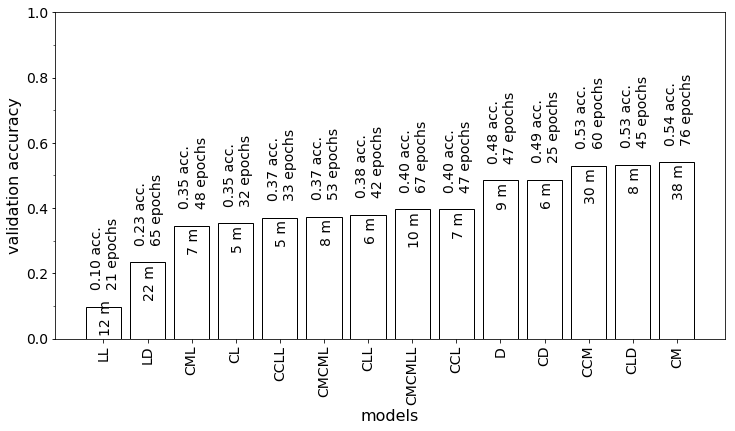

In [31]:
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots(figsize=(12,6))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
# plt.grid(linestyle='--', which='minor')
ax.bar(data3['name'], data3['val_categorical_accuracy'], fill=False)
plt.xticks(rotation='vertical')
plt.ylim((0, 1))
plt.ylabel('validation accuracy', fontsize=16)
plt.xlabel('models', fontsize=16)
ax.tick_params(labelsize=14)
for i,idx in enumerate(data3.index):
    row = data3.iloc[i]
    v = row['val_categorical_accuracy']
    e = row['Epochs']
    tm = row['elapsed']
    t = ax.annotate('%0.2f acc.\n%d epochs'%(v,e), (i-0.3, v+0.19),fontsize=14)
    t.set_rotation(90)
    if i==0:
        t = ax.annotate('%d m'%(tm/60), (i-0.1, v-0.01),fontsize=14)
    else:
        t = ax.annotate('%d m'%(tm/60), (i-0.1, v-0.04),fontsize=14)
    t.set_rotation(90)    